#  Demand Forecasting

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

#Plotting:
import matplotlib.pyplot as plt
import plotly.express as px
from IPython.display import HTML # HTML display function

from plotly.graph_objects import FigureWidget
from plotly.subplots import make_subplots
import ipywidgets as widgets
from ipywidgets import HBox, VBox, interactive_output
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#Time
from datetime import datetime as datetime
from datetime import timedelta
import time
from tqdm import tqdm
import holidays

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, TimeSeriesSplit
import optuna

#Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
import xgboost as xgb 

Datasets: 
- Retail Chain Demand Forecast Dataset

In [2]:
train = pd.read_csv('data//retail_chain_data.csv')
train.head()

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
0,1,17/01/11,8091,216418,99.0375,111.8625,0,0,20
1,2,17/01/11,8091,216419,99.0375,99.0375,0,0,28
2,3,17/01/11,8091,216425,133.9500,133.9500,0,0,19
3,4,17/01/11,8091,216233,133.9500,133.9500,0,0,44
4,5,17/01/11,8091,217390,141.0750,141.0750,0,0,52


## EDA

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150150 entries, 0 to 150149
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   record_ID        150150 non-null  int64  
 1   week             150150 non-null  object 
 2   store_id         150150 non-null  int64  
 3   sku_id           150150 non-null  int64  
 4   total_price      150149 non-null  float64
 5   base_price       150150 non-null  float64
 6   is_featured_sku  150150 non-null  int64  
 7   is_display_sku   150150 non-null  int64  
 8   units_sold       150150 non-null  int64  
dtypes: float64(2), int64(6), object(1)
memory usage: 10.3+ MB


In [4]:
# Missing values check 
train.isnull().sum()


record_ID          0
week               0
store_id           0
sku_id             0
total_price        1
base_price         0
is_featured_sku    0
is_display_sku     0
units_sold         0
dtype: int64

In [5]:
# Fill the single missing total_price with base_price
train['total_price'].fillna(train['base_price'], inplace=True)


C:\Users\ramme\AppData\Local\Temp\ipykernel_3860\751525247.py:2: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





In [6]:
train.isnull().sum()

record_ID          0
week               0
store_id           0
sku_id             0
total_price        0
base_price         0
is_featured_sku    0
is_display_sku     0
units_sold         0
dtype: int64

In [7]:
# changed to dateTime
train['week'] = pd.to_datetime(train['week'], format = '%d/%m/%y')

In [8]:
train.describe()


,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
count,150150.000000,150150,150150.000000,150150.000000,150150.000000,150150.000000,150150.000000,150150.000000,150150.000000
mean,106271.555504,2012-04-13 01:06:27.692307712,9199.422511,254761.132468,206.628502,219.425927,0.095611,0.133200,51.674206
min,1.000000,2011-01-17 00:00:00,8023.000000,216233.000000,41.325000,61.275000,0.000000,0.000000,1.000000
25%,53111.250000,2011-08-29 00:00:00,8562.000000,217217.000000,130.387500,133.237500,0.000000,0.000000,20.000000
50%,106226.500000,2012-04-13 12:00:00,9371.000000,222087.000000,198.075000,205.912500,0.000000,0.000000,35.000000
75%,159452.750000,2012-11-27 00:00:00,9731.000000,245338.000000,233.700000,234.412500,0.000000,0.000000,62.000000
max,212644.000000,2013-07-09 00:00:00,9984.000000,679023.000000,562.162500,562.162500,1.000000,1.000000,2876.000000
std,61386.037861,NaN,615.591445,85547.306447,103.310400,110.961712,0.294058,0.339792,60.207904


## Distribution of target (units_sold)

In [9]:
import sys
import nbformat
import plotly
print('sys.executable =', sys.executable)
print('nbformat version =', getattr(nbformat, '__version__', None))
print('plotly version =', plotly.__version__)


sys.executable = c:\Users\ramme\AppData\Local\Programs\Python\Python310\python.exe
nbformat version = 5.10.4
plotly version = 6.3.1


In [10]:
fig = px.histogram(train,
                   x="units_sold",
                   title='Distribution of Units Sold',
                   labels={'units_sold': 'Units Sold'},
                   nbins=50,
                   template='plotly_white',
                   color_discrete_sequence=['#636EFA'])
fig.update_layout(
    xaxis_title_text='Units Sold',
    yaxis_title_text='Frequency',
    bargap=0.1,
    title_x=0.5,
    width=600,
    height=400,
)
# Use to_html + IPython.display.HTML to avoid plotly.show renderer issues in this environment
import plotly.io as pio
from IPython.display import HTML
HTML(pio.to_html(fig, include_plotlyjs='cdn'))


-  The data is right skewed! But as it has a semi-log-normal distribution, we might still be able to use all data vailable to us, but we need to explore more:

In [11]:
x_transformed = np.log1p(train['units_sold'])

fig = px.histogram(x=x_transformed,
                   title='Distribution of Log(1 + Units Sold)',
                   labels={'x': 'Log(1 + Units Sold)'}, 
                   nbins=50,
                   template='plotly_white',
                   color_discrete_sequence=['#636EFA'])
fig.update_layout(
    xaxis_title_text='Log(1 + Units Sold)', 
    yaxis_title_text='Frequency',
    bargap=0.1,
    title_x=0.5,
    width=600,
    height=400,
)
# Use to_html + IPython.display.HTML to avoid plotly.show renderer issues in this environment
import plotly.io as pio
from IPython.display import HTML
HTML(pio.to_html(fig, include_plotlyjs='cdn'))


-  Since log1p of units_sold shows a normal distribution, I will use this transformed value in building the prediction model; and I can use all of the data, eliminating the need for dropping outliers. At the end, I will simply need to transform the predictions back to their original scale by using the function np.exp1m().

###  Sales trends over time (check seasonality)

In [12]:
import plotly.express as px
from statsmodels.tsa.seasonal import seasonal_decompose

# 1. Aggregate sales by week
# We sum up all units_sold for each week to get one single time series
total_sales_per_week = train.groupby('week')['units_sold'].sum()

# 2. Plot the total sales over time
fig = px.line(total_sales_per_week,
              x=total_sales_per_week.index,
              y='units_sold',
              title='Total Units Sold Per Week (All Stores & SKUs)',
              labels={'units_sold': 'Total Units Sold', 'week': 'Date'})
fig.update_layout(title_x=0.5, template='plotly_white')
fig.show()

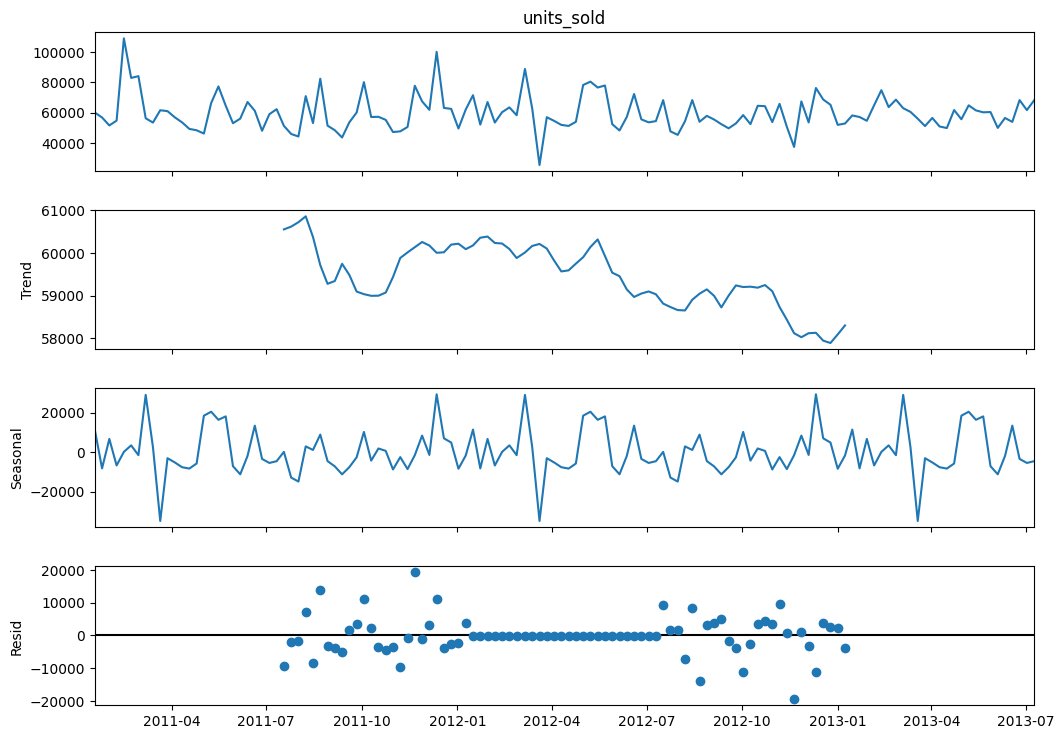

In [13]:
# 3. Decompose the aggregated time series
# We use period=52 because the data is weekly, and we
# expect an annual (yearly) seasonal pattern.
result = seasonal_decompose(total_sales_per_week,
                            model='additive',
                            period=52)

# 4. Plot the decomposed components
# This will show you four plots:
# 1. Observed (the original plot)
# 2. Trend (the long-term direction)
# 3. Seasonal (the repeating yearly pattern)
# 4. Residual (the leftover noise)

fig = result.plot()
fig.set_size_inches(12, 8)

### Correlation matrix 

In [14]:
cols = [
    'base_price', 'total_price', 'is_featured_sku', 'is_display_sku', 'units_sold'
]

corr_matrix = train[cols].corr()

fig = px.imshow(
    corr_matrix,
    text_auto=True,
    aspect="auto",
    labels=dict(color="Correlation"),
    title='Feature Correlation Matrix',
    color_continuous_scale='RdBu_r'
)
fig.update_layout(
    title_x=0.5,
    width=650,
    height=650
)

# Embed plot as HTML to avoid renderer errors
import plotly.io as pio
from IPython.display import HTML
HTML(pio.to_html(fig, include_plotlyjs='cdn'))

- The positive correlations of featuring and displaying, and the negative correlations of prices with units_sold make sense. That is an indicator of good data so far.

Since the correlations of prices are not as large as we would want, we will engineer new features based on them in the next section. There, we will also assess the impact of features on our Baseline model.

## Feature Engineering 

#### Price Features

In [15]:
train['diff'] = train['base_price'] - train['total_price']
train['relative_diff_total'] = train['diff']/train['total_price']
train['relative_diff_base'] = train['diff']/train['base_price']

cols = [
    'base_price', 'total_price', 'diff', 'relative_diff_base', 'relative_diff_total',
    'is_featured_sku', 'is_display_sku', 'units_sold'
]

corr_matrix = train[cols].corr()
fig = px.imshow(
    corr_matrix,
    text_auto=True,
    aspect="auto",
    labels=dict(color="Correlation"),
    title='Feature Correlation Matrix',
    color_continuous_scale='RdBu_r'
)
fig.update_layout(
    title_x=0.5,
    width=800,
    height=800
)

# Embed plot as HTML to avoid renderer errors
import plotly.io as pio
from IPython.display import HTML
HTML(pio.to_html(fig, include_plotlyjs='cdn'))

### Scenario - A 
- Inlcude lags 

In [16]:
# First, add the log-transformed target variable we discussed
train['log_units_sold'] = np.log1p(train['units_sold'])

# --- Sort data (CRITICAL for panel data) ---
# This ensures that when we .shift() data, we are getting the
# previous week for the SAME item.
df = train.sort_values(by=['store_id', 'sku_id', 'week'])

# --- 1. Create Baseline Features (Lags & Time) ---
print("Creating baseline features...")

# We use .groupby() to create these features for each store/sku pair.
# .shift(1) means "get the value from 1 week ago".
df['log_sales_lag_1'] = df.groupby(['store_id', 'sku_id'])['log_units_sold'].shift(1)
df['log_sales_lag_2'] = df.groupby(['store_id', 'sku_id'])['log_units_sold'].shift(2)
df['log_sales_lag_3'] = df.groupby(['store_id', 'sku_id'])['log_units_sold'].shift(3)
df['log_sales_lag_4'] = df.groupby(['store_id', 'sku_id'])['log_units_sold'].shift(4) # 1 month ago


# Create time features from the 'week' column
# We already have 'month', let's add week_of_year
# df['week_of_year'] = df['week'].dt.isocalendar().week


# --- 3. Clean up ---
print("Cleaning up NaNs...")
# Lags and rolling features create NaNs at the start.
# We must drop them before modeling.
df_features = df.dropna()

print(f"Original rows: {len(df)}, Rows after dropping NaNs: {len(df_features)}")
print("Feature engineering complete!")

# You can check the new features:
df_features

Creating baseline features...
Cleaning up NaNs...
Original rows: 150150, Rows after dropping NaNs: 145530
Feature engineering complete!


,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold,diff,relative_diff_total,relative_diff_base,log_units_sold,log_sales_lag_1,log_sales_lag_2,log_sales_lag_3,log_sales_lag_4
4695,6651,2011-02-14,8023,216233,133.2375,133.2375,0,0,93,0.0000,0.000000,0.000000,4.543295,4.753590,4.912655,4.477337,4.744932
5850,8289,2011-02-21,8023,216233,115.4250,133.2375,0,0,150,17.8125,0.154321,0.133690,5.017280,4.543295,4.753590,4.912655,4.477337
7005,9923,2011-02-28,8023,216233,115.4250,133.2375,0,0,134,17.8125,0.154321,0.133690,4.905275,5.017280,4.543295,4.753590,4.912655
8160,11537,2011-03-07,8023,216233,117.5625,133.2375,0,0,130,15.6750,0.133333,0.117647,4.875197,4.905275,5.017280,4.543295,4.753590
9315,13151,2011-03-14,8023,216233,116.1375,133.2375,0,0,167,17.1000,0.147239,0.128342,5.123964,4.875197,4.905275,5.017280,4.543295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145529,206086,2013-06-11,9984,679023,234.4125,234.4125,0,1,7,0.0000,0.000000,0.000000,2.079442,1.945910,2.079442,3.688879,3.332205
146684,207725,2013-06-18,9984,679023,234.4125,234.4125,0,1,15,0.0000,0.000000,0.000000,2.772589,2.079442,1.945910,2.079442,3.688879
147839,209363,2013-06-25,9984,679023,234.4125,234.4125,0,0,20,0.0000,0.000000,0.000000,3.044522,2.772589,2.079442,1.945910,2.079442
148994,211002,2013-07-02,9984,679023,234.4125,234.4125,0,1,15,0.0000,0.000000,0.000000,2.772589,3.044522,2.772589,2.079442,1.945910


In [17]:
import pandas as pd

# --- 1. Define the Train/Test Split Date ---
# We'll set aside the last 32 weeks of data as our "test set".
max_date = df_features['week'].max()
test_cutoff_date = max_date - pd.DateOffset(weeks=32)

# Split the data
train_df = df_features[df_features['week'] <= test_cutoff_date]
test_df = df_features[df_features['week'] > test_cutoff_date]

print(f"--- Data Split ---")
print(f"Training data from: {train_df['week'].min().date()} to {train_df['week'].max().date()}")
print(f"Testing data from:  {test_df['week'].min().date()} to {test_df['week'].max().date()}")
print(f"Training set size: {len(train_df)} rows")
print(f"Testing set size:  {len(test_df)} rows")


--- Data Split ---
Training data from: 2011-02-14 to 2012-11-27
Testing data from:  2012-12-04 to 2013-07-09
Training set size: 108570 rows
Testing set size:  36960 rows


In [18]:
# 1. Total unique weeks in the full dataset (after NaNs dropped)
total_weeks = df_features['week'].nunique()
print(f"Total unique weeks in df_features: {total_weeks}")

# 2. Number of unique weeks in the training set
train_weeks = train_df['week'].nunique()
print(f"Weeks in training set (train_df): {train_weeks}")

# 3. Number of unique weeks in the test set
test_weeks = test_df['week'].nunique()
print(f"Weeks in test set (test_df): {test_weeks}")

print(f"\nSummary: Your data is split into {train_weeks} training weeks and {test_weeks} testing weeks.")

Total unique weeks in df_features: 126
Weeks in training set (train_df): 94
Weeks in test set (test_df): 32

Summary: Your data is split into 94 training weeks and 32 testing weeks.


In [19]:

# --- 2. Define the Feature List for SCENARIO 1 ---

# SCENARIO 1: BASELINE MODEL
# Only uses features derived from past sales (lags, rolling) and time.
FEATURES_BASELINE = [
    'log_sales_lag_1',
    'log_sales_lag_2',
    'log_sales_lag_3',
    'log_sales_lag_4',
    
]

TARGET = 'log_units_sold' # Our target is the log-transformed value

# --- 3. Create the Final X (features) and y (target) Datasets ---

# --- For Baseline Model ---
X_train_base = train_df[FEATURES_BASELINE]
y_train_base = train_df[TARGET]
X_test_base = test_df[FEATURES_BASELINE]
y_test_base = test_df[TARGET]

print("\n--- Baseline Datasets Created ---")
print(f"Baseline model will use {len(FEATURES_BASELINE)} features.")
print(f"X_train_base shape: {X_train_base.shape}")
print(f"X_test_base shape: {X_test_base.shape}")


--- Baseline Datasets Created ---
Baseline model will use 4 features.
X_train_base shape: (108570, 4)
X_test_base shape: (36960, 4)


In [20]:
X_train_base.head()

,log_sales_lag_1,log_sales_lag_2,log_sales_lag_3,log_sales_lag_4
4695,4.753590,4.912655,4.477337,4.744932
5850,4.543295,4.753590,4.912655,4.477337
7005,5.017280,4.543295,4.753590,4.912655
8160,4.905275,5.017280,4.543295,4.753590
9315,4.875197,4.905275,5.017280,4.543295


In [21]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# --- 1. Define Models ---
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1, early_stopping_rounds=10)
}

# --- 2. Get Actual Test Values ---
# We do this once. We need the un-logged 'units_sold' for evaluation
y_test_actual = np.expm1(y_test_base)

# --- 3. Train and Evaluate Each Model ---
results = {}

for name, model in models.items():
    print(f"--- Training {name} ---")
    
    if name == "XGBoost":
        # XGBoost can use an evaluation set to prevent overfitting
        model.fit(X_train_base, y_train_base,
                  eval_set=[(X_test_base, y_test_base)],
                  verbose=False)
    else:
        # Other models
        model.fit(X_train_base, y_train_base)

    # --- Make Predictions (in log scale) ---
    preds_log = model.predict(X_test_base)
    
    # --- Convert back to actual units_sold scale ---
    preds_actual = np.expm1(preds_log)
    
    # --- Calculate Error ---
    rmse = np.sqrt(mean_squared_error(y_test_actual, preds_actual))
    mae = mean_absolute_error(y_test_actual, preds_actual)
    
    # --- Store Results ---
    results[name] = {"RMSE": rmse, "MAE": mae}
    print(f"{name} training complete.")

# --- 4. Display Results ---
print("\n--- Baseline Model Comparison Excluding Extra Features ---")

# Convert results to a DataFrame for easy viewing
results_df = pd.DataFrame(results).T.sort_values(by="MAE")

print(results_df)

print(f"\nBest Baseline Model: {results_df.index[0]}")

--- Training Linear Regression ---
Linear Regression training complete.
--- Training Random Forest ---
Random Forest training complete.
--- Training XGBoost ---
XGBoost training complete.

--- Baseline Model Comparison Excluding Extra Features ---
                        RMSE        MAE
XGBoost            41.767511  18.721055
Linear Regression  41.553979  19.146951
Random Forest      42.290362  19.914100

Best Baseline Model: XGBoost


## Aggregated Actual vs Predicted sales across all SKUs for your Scenario 1 (baseline model)

--- Plotting Aggregated Forecast for Best Baseline Model: XGBoost ---


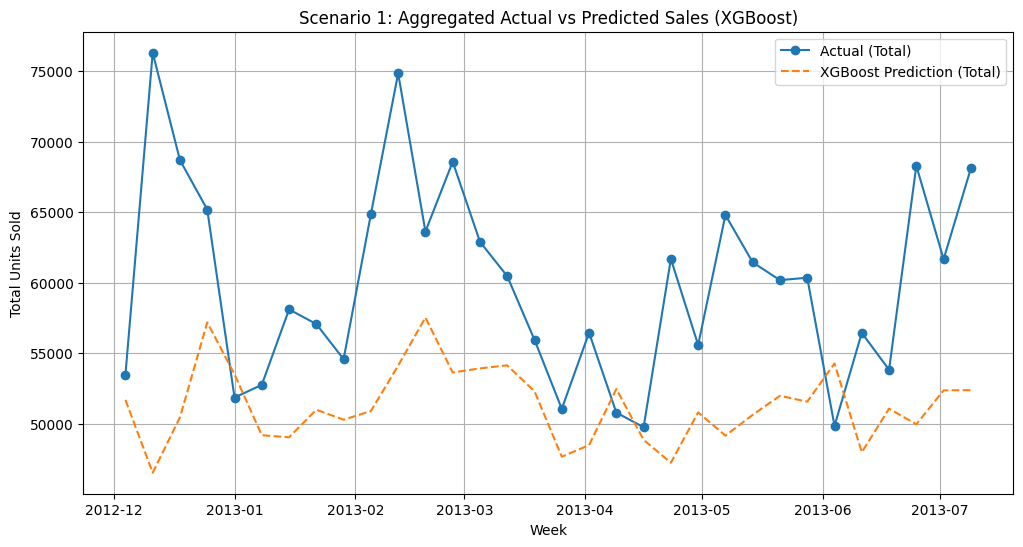

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Get Predictions from Best Model ---
best_model_name = results_df.index[0]
best_model = models[best_model_name]
print(f"--- Plotting Aggregated Forecast for Best Baseline Model: {best_model_name} ---")

# Make predictions (log scale)
preds_log = best_model.predict(X_test_base)

# Convert predictions and test data to actual units
preds_actual = np.expm1(preds_log)
y_test_actual = np.expm1(y_test_base)

# Combine with test dataframe
plot_df = test_df.copy()
plot_df['Actual Units Sold'] = y_test_actual
plot_df['Predicted Units Sold'] = preds_actual

# --- 2. Aggregate all SKUs per week ---
agg_plot_df = plot_df.groupby('week', as_index=False).agg({
    'Actual Units Sold': 'sum',
    'Predicted Units Sold': 'sum'
})

# --- 3. Plot aggregated Actual vs Predicted ---
plt.figure(figsize=(12, 6))
plt.plot(agg_plot_df['week'], agg_plot_df['Actual Units Sold'], label='Actual (Total)', marker='o')
plt.plot(agg_plot_df['week'], agg_plot_df['Predicted Units Sold'], label=f'{best_model_name} Prediction (Total)', linestyle='--')
plt.legend()
plt.title(f"Scenario 1: Aggregated Actual vs Predicted Sales ({best_model_name})")
plt.xlabel("Week")
plt.ylabel("Total Units Sold")
plt.grid(True)
plt.show()


In [23]:
import plotly.graph_objects as go
import numpy as np

# --- 1. Setup: Get Best Model & Create 'plot_df' ---
# (This assumes 'models', 'results_df', 'test_df', 'train_df',
# 'X_test_base', 'y_test_base', 'test_cutoff_date' exist)

# Get the best model from your comparison
best_model_name = results_df.index[0]
best_model = models[best_model_name]

print(f"--- Visualizing Best Baseline Model: {best_model_name} ---")

# Create predictions (log scale)
preds_log = best_model.predict(X_test_base)

# Convert predictions and test data to actual units
preds_actual = np.expm1(preds_log)
y_test_actual = np.expm1(y_test_base)

# Create the main DataFrame for plotting
plot_df = test_df.copy()
plot_df['Actual Units Sold'] = y_test_actual
plot_df['Predicted Units Sold'] = preds_actual

print("plot_df DataFrame created successfully.")

# --- 2. Plot 2: Selectable Time-Series Forecast Plot ---
# This shows how the model performed for one specific item.

# --- First, see your top 10 options ---
print("\n--- Top 10 Items in Test Set (Store ID, SKU ID) ---")
print(plot_df.groupby(['store_id', 'sku_id']).size().nlargest(10))

# --- SET YOUR SELECTION HERE ---
# (Change these IDs to explore different items)
STORE_TO_PLOT = 8023
SKU_TO_PLOT = 216233
WEEKS_OF_TRAIN_HISTORY = 50 # How many weeks of history to show
# ---------------------------------

print(f"\nPlotting time-series for Store: {STORE_TO_PLOT}, SKU: {SKU_TO_PLOT}")
print(f"Showing last {WEEKS_OF_TRAIN_HISTORY} weeks of training data for context.")


--- Visualizing Best Baseline Model: XGBoost ---
plot_df DataFrame created successfully.

--- Top 10 Items in Test Set (Store ID, SKU ID) ---
store_id  sku_id
8023      216233    32
          216418    32
          216419    32
          216425    32
          217390    32
          219009    32
          219029    32
          222087    32
          222765    32
          223153    32
dtype: int64

Plotting time-series for Store: 8023, SKU: 216233
Showing last 50 weeks of training data for context.


In [24]:
# --- Select training history for the chosen store and SKU ---
item_train_df = (
    train_df
    .query("store_id == @STORE_TO_PLOT and sku_id == @SKU_TO_PLOT")
    .sort_values("week")
    .tail(WEEKS_OF_TRAIN_HISTORY)
)

# Convert log sales back to actual unit sales
item_train_actual_sales = np.expm1(item_train_df["log_units_sold"])

# --- Select test data (with predictions) for the same item ---
item_test_df = (
    plot_df
    .query("store_id == @STORE_TO_PLOT and sku_id == @SKU_TO_PLOT")
    .sort_values("week")
)

# --- Validate data availability ---
if item_train_df.empty and item_test_df.empty:
    print(f"No data found for Store {STORE_TO_PLOT}, SKU {SKU_TO_PLOT}.")
else:
    # --- Initialize the time series plot ---
    fig_ts = go.Figure()

    # Training: Actual Sales
    fig_ts.add_trace(go.Scatter(
        x=item_train_df["week"],
        y=item_train_actual_sales,
        mode="lines+markers",
        name="Actual Sales (Train)",
        line=dict(color="royalblue")
    ))

    # Test: Actual Sales
    fig_ts.add_trace(go.Scatter(
        x=item_test_df["week"],
        y=item_test_df["Actual Units Sold"],
        mode="lines+markers",
        name="Actual Sales (Test)",
        line=dict(color="royalblue")
    ))

    # Test: Predicted Sales
    fig_ts.add_trace(go.Scatter(
        x=item_test_df["week"],
        y=item_test_df["Predicted Units Sold"],
        mode="lines+markers",
        name="Predicted Sales (Baseline)",
        line=dict(color="firebrick", dash="dash")
    ))

    # --- Train/Test Split Line ---
    fig_ts.add_vline(
        x=pd.Timestamp(test_cutoff_date),
        line_width=2,
        line_dash="dot",
        line_color="grey"
    )

    # --- Annotation for Train/Test Split ---
    fig_ts.add_annotation(
        x=pd.Timestamp(test_cutoff_date),
        y=max(item_test_df["Actual Units Sold"].max(), item_train_actual_sales.max()) * 1.05,
        text="Train/Test Split",
        showarrow=False,
        font=dict(color="grey", size=10),
        xanchor="left"
    )

    # --- Final layout ---
    fig_ts.update_layout(
        title=(
            f"{best_model_name} (Baseline): Forecast vs Actuals<br>"
            f"(Store: {STORE_TO_PLOT}, SKU: {SKU_TO_PLOT})"
        ),
        xaxis_title="Week",
        yaxis_title="Units Sold",
        template="plotly_white",
        title_x=0.5
    )

    fig_ts.show()


### Prophet Implementation in Scenario 1

In [25]:

import pandas as pd
from prophet import Prophet



In [26]:
# Prophet requires columns named 'ds' (date) and 'y' (target)
prophet_train = train_df[['week', 'log_units_sold']].rename(columns={
    'week': 'ds',
    'log_units_sold': 'y'
})

prophet_test = test_df[['week', 'log_units_sold']].rename(columns={
    'week': 'ds',
    'log_units_sold': 'y'
})

In [27]:
prophet_train.head(5)

,ds,y
4695,2011-02-14,4.543295
5850,2011-02-21,5.017280
7005,2011-02-28,4.905275
8160,2011-03-07,4.875197
9315,2011-03-14,5.123964


In [28]:
# Initialize Prophet model
prophet_model = Prophet()

In [29]:
# Fit model
prophet_model.fit(prophet_train)

15:48:41 - cmdstanpy - INFO - Chain [1] start processing
15:49:00 - cmdstanpy - INFO - Chain [1] done processing


In [30]:
# Create future dataframe for test period
future = pd.DataFrame({'ds': prophet_test['ds']})


In [31]:
# Forecast
forecast = prophet_model.predict(future)


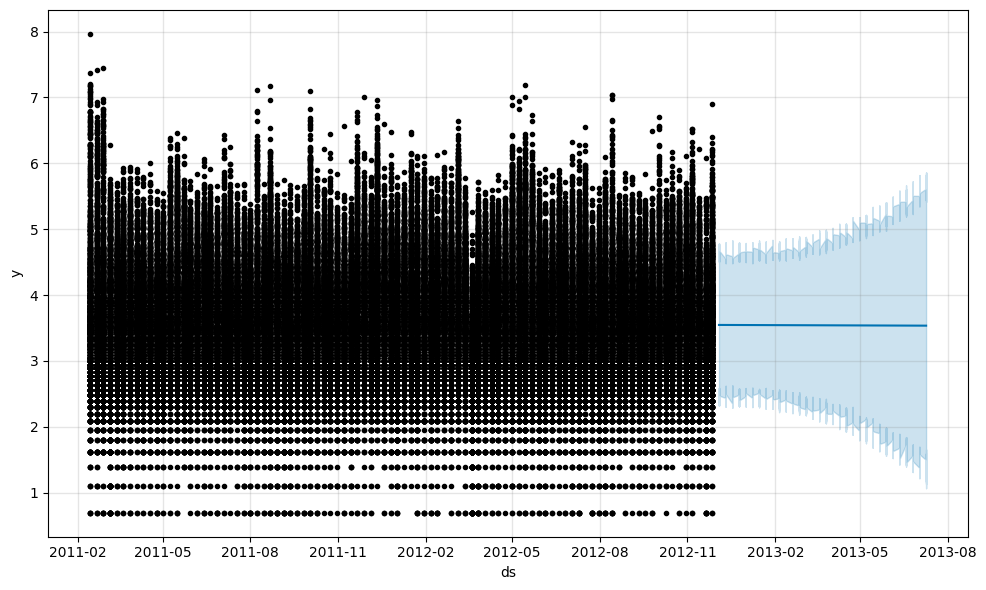

In [32]:


# Python
fig1 = prophet_model.plot(forecast)



In [33]:
# --- Merge Predictions ---
prophet_forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].copy()
prophet_forecast = prophet_forecast.merge(prophet_test, on='ds', how='left')


In [34]:
prophet_forecast.head()

,ds,yhat,yhat_lower,yhat_upper,y
0,2012-12-04,3.545609,2.38877,4.602948,4.779123
1,2012-12-04,3.545609,2.38877,4.602948,5.278115
2,2012-12-04,3.545609,2.38877,4.602948,5.087596
3,2012-12-04,3.545609,2.38877,4.602948,4.430817
4,2012-12-04,3.545609,2.38877,4.602948,5.389072


In [35]:

# --- Convert back from log scale ---
prophet_forecast['actual_sales'] = np.expm1(prophet_forecast['y'])
prophet_forecast['predicted_sales'] = np.expm1(prophet_forecast['yhat'])


In [36]:
# 5. Evaluate Prophet Performance ========================
# ============================================================

from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(prophet_forecast['actual_sales'], prophet_forecast['predicted_sales'])
rmse = np.sqrt(mean_squared_error(prophet_forecast['actual_sales'], prophet_forecast['predicted_sales']))

print("\n--- Prophet Model Results without including extra Features ---")
print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")



--- Prophet Model Results without including extra Features ---
MAE  : 32.6119
RMSE : 60.4334


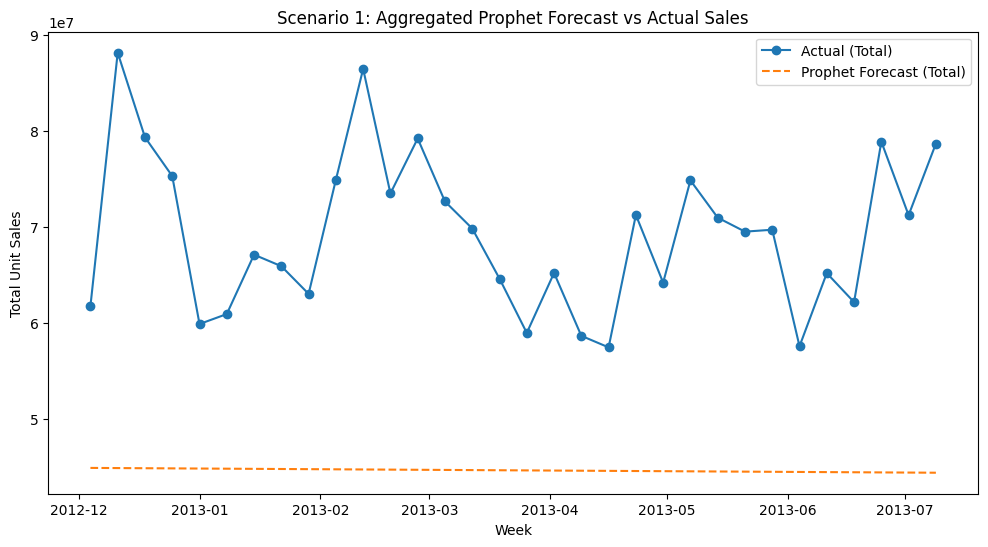

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Aggregate actual and predicted sales per week
agg_forecast = prophet_forecast.groupby('ds', as_index=False).agg({
    'actual_sales': 'sum',
    'predicted_sales': 'sum',
})

# Plot aggregated forecast vs actual
plt.figure(figsize=(12, 6))
plt.plot(agg_forecast['ds'], agg_forecast['actual_sales'], label='Actual (Total)', marker='o')
plt.plot(agg_forecast['ds'], agg_forecast['predicted_sales'], label='Prophet Forecast (Total)', linestyle='--')

plt.legend()
plt.title("Scenario 1: Aggregated Prophet Forecast vs Actual Sales")
plt.xlabel("Week")
plt.ylabel("Total Unit Sales")
plt.show()


## Scenario 2 with Extra Features
- Add the Holiday Feature
-  Promotional Features

In [38]:
from holidays import US as USHolidays
from datetime import timedelta

print("Adding holiday feature...")

# 1. Get all unique years from our dataset
years_in_data = df_features['week'].dt.year.unique()

# 2. Get all US holiday dates for those years
us_holidays = USHolidays(years=years_in_data)
holiday_dates = set(us_holidays.keys())

# 3. Create a set of all week-start dates that contain a holiday
# (This is your smart logic)
holiday_week_starts = set()
for h_date in holiday_dates:
    # A week starting on any of the 7 days
    # leading up to and including a holiday
    # will contain that holiday.
    for i in range(7):
        possible_start_date = h_date - timedelta(days=i)
        holiday_week_starts.add(possible_start_date)

# 4. Create the new 'is_holiday' feature
# We use .dt.date to compare dates only (ignoring time)
df_features['is_holiday'] = df_features['week'].dt.date.isin(holiday_week_starts).astype(int)

print("Holiday feature added.")
print(f"Total holiday weeks found: {df_features['is_holiday'].sum()}")

# Check a few of them:
print(df_features[df_features['is_holiday'] == 1][['week', 'is_holiday']].head())

Adding holiday feature...
Holiday feature added.
Total holiday weeks found: 27720
            week  is_holiday
5850  2011-02-21           1
22020 2011-05-30           1
27795 2011-07-04           1
38190 2011-09-05           1
43965 2011-10-10           1


C:\Users\ramme\AppData\Local\Temp\ipykernel_3860\2132829585.py:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [39]:
# (This is the same split code as before)
max_date = df_features['week'].max()
test_cutoff_date = max_date - pd.DateOffset(weeks=32)

train_df = df_features[df_features['week'] <= test_cutoff_date]
test_df = df_features[df_features['week'] > test_cutoff_date]

print("\nData has been re-split to include the new holiday feature.")


Data has been re-split to include the new holiday feature.


In [40]:
# --- 1. Define the NEW Enriched Feature List ---
FEATURES_ENRICHED = FEATURES_BASELINE + [
    'is_featured_sku',
    'is_display_sku',
    'is_holiday'  # <-- Our new feature!
]

print(f"New Scenario 2 will use {len(FEATURES_ENRICHED)} features (Promos + Holidays).")

# --- 2. Create the new X/y datasets ---
X_train_rich = train_df[FEATURES_ENRICHED]
y_train_rich = train_df[TARGET]
X_test_rich = test_df[FEATURES_ENRICHED]
y_test_rich = test_df[TARGET]


New Scenario 2 will use 7 features (Promos + Holidays).


In [41]:
X_train_rich

,log_sales_lag_1,log_sales_lag_2,log_sales_lag_3,log_sales_lag_4,is_featured_sku,is_display_sku,is_holiday
4695,4.753590,4.912655,4.477337,4.744932,0,0,0
5850,4.543295,4.753590,4.912655,4.477337,0,0,1
7005,5.017280,4.543295,4.753590,4.912655,0,0,0
8160,4.905275,5.017280,4.543295,4.753590,0,0,0
9315,4.875197,4.905275,5.017280,4.543295,0,0,0
...,...,...,...,...,...,...,...
108569,2.772589,2.639057,2.639057,2.397895,0,1,0
109724,2.397895,2.772589,2.639057,2.639057,0,0,1
110879,2.484907,2.397895,2.772589,2.639057,0,1,0
112034,3.465736,2.484907,2.397895,2.772589,0,1,1


In [42]:
# --- 3. Train and Evaluate Each Model on ENRICHED Data ---
results_rich = {}
predictions_rich = {}

for name, model in models.items():
    print(f"--- Training {name} (Scenario 2: Promo + Holiday) ---")
    
    # Fit models
    if name == "XGBoost":
        model.fit(X_train_rich, y_train_rich,
                  eval_set=[(X_test_rich, y_test_rich)],
                  verbose=False)
    else:
        model.fit(X_train_rich, y_train_rich)
    
    # --- Make Predictions ---
    preds_log_rich = model.predict(X_test_rich)
    preds_actual_rich = np.expm1(preds_log_rich)
    
    # --- Calculate Error Metrics ---
    rmse_rich = np.sqrt(mean_squared_error(y_test_actual, preds_actual_rich))
    mae_rich = mean_absolute_error(y_test_actual, preds_actual_rich)
    
    # --- Store Results ---
    results_rich[name] = {"RMSE": rmse_rich, "MAE": mae_rich}
    predictions_rich[name] = preds_actual_rich
    print(f"{name} training complete.")

# --- 4. Display Enriched Model Results ---
print("\n--- (Promo + Holiday) Model Comparison ---")
results_rich_df = pd.DataFrame(results_rich).T.sort_values(by="MAE")
display(results_rich_df)

# --- 5. Prepare Plot Data for One Model (e.g., Best Performing) ---
best_model_name = results_rich_df.index[0]
print(f"\nBest Model (Scenario 2): {best_model_name}")

# Add predictions to test dataframe for plotting
plot_df["Predicted Units Sold"] = predictions_rich[best_model_name]
plot_df["Actual Units Sold"] = y_test_actual


--- Training Linear Regression (Scenario 2: Promo + Holiday) ---
Linear Regression training complete.
--- Training Random Forest (Scenario 2: Promo + Holiday) ---
Random Forest training complete.
--- Training XGBoost (Scenario 2: Promo + Holiday) ---
XGBoost training complete.

--- (Promo + Holiday) Model Comparison ---


,RMSE,MAE
XGBoost,34.983141,16.994791
Random Forest,34.393761,17.508616
Linear Regression,35.142343,18.257599



Best Model (Scenario 2): XGBoost


In [43]:


# --- 6. Plot Forecast vs Actuals for Selected Store & SKU ---
item_train_df = (
    train_df
    .query("store_id == @STORE_TO_PLOT and sku_id == @SKU_TO_PLOT")
    .sort_values("week")
    .tail(WEEKS_OF_TRAIN_HISTORY)
)

item_train_actual_sales = np.expm1(item_train_df["log_units_sold"])

item_test_df = (
    plot_df
    .query("store_id == @STORE_TO_PLOT and sku_id == @SKU_TO_PLOT")
    .sort_values("week")
)

# --- Validate data availability ---
if item_train_df.empty and item_test_df.empty:
    print(f"No data found for Store {STORE_TO_PLOT}, SKU {SKU_TO_PLOT}.")
else:
    # --- Initialize the figure ---
    fig_ts = go.Figure()

    # Actual Train Sales
    fig_ts.add_trace(go.Scatter(
        x=item_train_df["week"],
        y=item_train_actual_sales,
        mode="lines+markers",
        name="Actual Sales (Train)",
        line=dict(color="royalblue")
    ))

    # Actual Test Sales
    fig_ts.add_trace(go.Scatter(
        x=item_test_df["week"],
        y=item_test_df["Actual Units Sold"],
        mode="lines+markers",
        name="Actual Sales (Test)",
        line=dict(color="royalblue")
    ))

    # Predicted Test Sales (Scenario 2)
    fig_ts.add_trace(go.Scatter(
        x=item_test_df["week"],
        y=item_test_df["Predicted Units Sold"],
        mode="lines+markers",
        name=f"Predicted Sales ({best_model_name})",
        line=dict(color="firebrick", dash="dash")
    ))

    # Vertical line at Train/Test split
    fig_ts.add_vline(
        x=pd.Timestamp(test_cutoff_date),
        line_width=2,
        line_dash="dot",
        line_color="grey"
    )

    # Annotation for split
    fig_ts.add_annotation(
        x=pd.Timestamp(test_cutoff_date),
        y=max(item_test_df["Actual Units Sold"].max(), item_train_actual_sales.max()) * 1.05,
        text="Train/Test Split",
        showarrow=False,
        font=dict(color="grey", size=10),
        xanchor="left"
    )

    # Final layout
    fig_ts.update_layout(
        title=(
            f"{best_model_name} (Scenario 2: Promo + Holiday)<br>"
            f"Forecast vs Actuals — Store {STORE_TO_PLOT}, SKU {SKU_TO_PLOT}"
        ),
        xaxis_title="Week",
        yaxis_title="Units Sold",
        template="plotly_white",
        title_x=0.5
    )

    fig_ts.show()


### Scenario 2: Aggregated Actual vs Predicted Sales (All SKUs)

--- Plotting Aggregated Forecast for Scenario 2 (Promo + Holiday): XGBoost ---


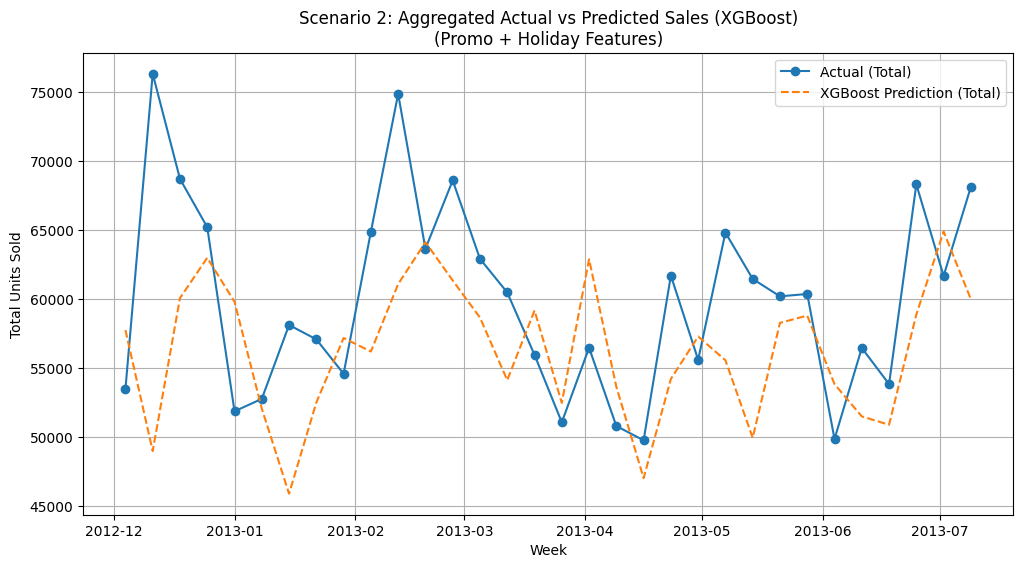

In [44]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --- 1. Get Best Model & Predictions ---
best_model_name = results_rich_df.index[0]  # ✅ Use the DataFrame, not dict
best_model = models[best_model_name]
print(f"--- Plotting Aggregated Forecast for Scenario 2 (Promo + Holiday): {best_model_name} ---")

# Get predictions in log scale
preds_log_rich = best_model.predict(X_test_rich)

# Convert from log scale to actual units
preds_actual_rich = np.expm1(preds_log_rich)
y_test_actual_rich = np.expm1(y_test_rich)

# Combine with test data
plot_df_rich = test_df.copy()
plot_df_rich['Actual Units Sold'] = y_test_actual_rich
plot_df_rich['Predicted Units Sold'] = preds_actual_rich

# --- 2. Aggregate across all SKUs and stores by week ---
agg_plot_df_rich = plot_df_rich.groupby('week', as_index=False).agg({
    'Actual Units Sold': 'sum',
    'Predicted Units Sold': 'sum'
})

# --- 3. Plot aggregated Actual vs Predicted ---
plt.figure(figsize=(12, 6))
plt.plot(agg_plot_df_rich['week'], agg_plot_df_rich['Actual Units Sold'], 
         label='Actual (Total)', marker='o')
plt.plot(agg_plot_df_rich['week'], agg_plot_df_rich['Predicted Units Sold'], 
         label=f'{best_model_name} Prediction (Total)', linestyle='--')
plt.legend()
plt.title(f"Scenario 2: Aggregated Actual vs Predicted Sales ({best_model_name})\n(Promo + Holiday Features)")
plt.xlabel("Week")
plt.ylabel("Total Units Sold")
plt.grid(True)
plt.show()


### Implementation of the prophet model -Scenario 2

In [45]:
# --- 1. Prepare train/test data with regressors ---
regressors = ['is_featured_sku', 'is_display_sku', 'is_holiday']

prophet_train2 = train_df[['week', 'log_units_sold'] + regressors].rename(columns={
    'week': 'ds',
    'log_units_sold': 'y'
})

In [46]:
prophet_train2.head()

,ds,y,is_featured_sku,is_display_sku,is_holiday
4695,2011-02-14,4.543295,0,0,0
5850,2011-02-21,5.017280,0,0,1
7005,2011-02-28,4.905275,0,0,0
8160,2011-03-07,4.875197,0,0,0
9315,2011-03-14,5.123964,0,0,0


In [47]:
prophet_test2 = test_df[['week', 'log_units_sold'] + regressors].rename(columns={
    'week': 'ds',
    'log_units_sold': 'y'
})

In [48]:
# --- 2. Initialize Prophet model ---
prophet_model_rich = Prophet()


In [49]:
# --- 3. Add extra regressors ---
for reg in regressors:
    prophet_model_rich.add_regressor(reg)


In [50]:
# --- 4. Fit model ---
prophet_model_rich.fit(prophet_train2)


15:49:46 - cmdstanpy - INFO - Chain [1] start processing
15:50:15 - cmdstanpy - INFO - Chain [1] done processing


In [51]:
# --- 5. Create future dataframe (test period) ---
future = prophet_test2[['ds'] + regressors]

# --- 6. Forecast ---
forecast_rich = prophet_model_rich.predict(future)



In [52]:

# --- 7. Merge with actuals ---
forecast_rich = forecast_rich[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].merge(
    prophet_test2[['ds', 'y']], on='ds', how='left'
)

In [53]:
forecast_rich.head()

,ds,yhat,yhat_lower,yhat_upper,y
0,2012-12-04,3.43567,2.42316,4.46595,4.779123
1,2012-12-04,3.43567,2.42316,4.46595,5.278115
2,2012-12-04,3.43567,2.42316,4.46595,5.087596
3,2012-12-04,3.43567,2.42316,4.46595,4.430817
4,2012-12-04,3.43567,2.42316,4.46595,5.389072


In [54]:
# --- 8. Convert back from log-scale ---
forecast_rich['actual_sales'] = np.expm1(forecast_rich['y'])
forecast_rich['predicted_sales'] = np.expm1(forecast_rich['yhat'])

# --- 9. Evaluate performance ---
mae = mean_absolute_error(forecast_rich['actual_sales'], forecast_rich['predicted_sales'])
rmse = np.sqrt(mean_squared_error(forecast_rich['actual_sales'], forecast_rich['predicted_sales']))

print("\n--- Prophet (Scenario 2: with Promo + Holiday)---")
print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")


--- Prophet (Scenario 2: with Promo + Holiday)---
MAE  : 36.4442
RMSE : 62.6373


### Aggregate sales across SKUs (total per week) - overall demand trend

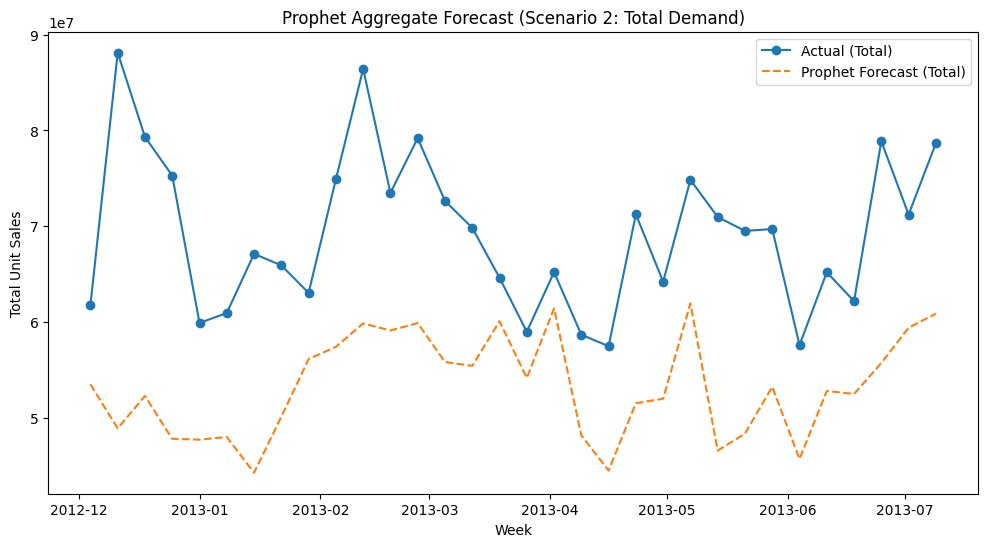

In [55]:
agg_df = (
    forecast_rich.groupby('ds', as_index=False)
    .agg({'actual_sales': 'sum', 'predicted_sales': 'sum'})
)

plt.figure(figsize=(12, 6))
plt.plot(agg_df['ds'], agg_df['actual_sales'], label='Actual (Total)', marker='o')
plt.plot(agg_df['ds'], agg_df['predicted_sales'], label='Prophet Forecast (Total)', linestyle='--')
plt.legend()
plt.title("Prophet Aggregate Forecast (Scenario 2: Total Demand)")
plt.xlabel("Week")
plt.ylabel("Total Unit Sales")
plt.show()


In [57]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# ================================================================
# --- 1. Prepare Aggregated Data for Scenario 1 ---
# ================================================================
best_base_model_name = results_df.index[0]
best_base_model = models[best_base_model_name]

preds_log_base = best_base_model.predict(X_test_base)
preds_actual_base = np.expm1(preds_log_base)
y_test_actual_base = np.expm1(y_test_base)

plot_df_base = test_df.copy()
plot_df_base["Actual Units Sold"] = y_test_actual_base
plot_df_base["Predicted Units Sold (Scenario 1)"] = preds_actual_base

agg_base = plot_df_base.groupby("week", as_index=False).agg({
    "Actual Units Sold": "sum",
    "Predicted Units Sold (Scenario 1)": "sum"
})


# ================================================================
# --- 2. Prepare Aggregated Data for Scenario 2 ---
# ================================================================
best_rich_model_name = results_rich_df.index[0]
best_rich_model = models[best_rich_model_name]

preds_log_rich = best_rich_model.predict(X_test_rich)
preds_actual_rich = np.expm1(preds_log_rich)
y_test_actual_rich = np.expm1(y_test_rich)

plot_df_rich = test_df.copy()
plot_df_rich["Actual Units Sold"] = y_test_actual_rich
plot_df_rich["Predicted Units Sold (Scenario 2)"] = preds_actual_rich

agg_rich = plot_df_rich.groupby("week", as_index=False).agg({
    "Actual Units Sold": "sum",
    "Predicted Units Sold (Scenario 2)": "sum"
})


# ================================================================
# --- 3. Prepare Aggregated Prophet Forecast ---
# ================================================================
# Ensure prophet_forecast dataframe exists with columns:
# ['ds', 'actual_sales', 'predicted_sales']
# Convert 'ds' to datetime if not already
prophet_forecast["ds"] = pd.to_datetime(prophet_forecast["ds"])

# Aggregate by week (if multiple stores/SKUs)
agg_prophet = prophet_forecast.groupby("ds", as_index=False).agg({
    "actual_sales": "sum",
    "predicted_sales": "sum"
})
agg_prophet.rename(columns={
    "ds": "week",
    "actual_sales": "Actual Units Sold (Prophet)",
    "predicted_sales": "Predicted Units Sold (Prophet)"
}, inplace=True)


# ================================================================
# --- 4. Merge All for Comparison ---
# ================================================================
agg_compare = (
    agg_base
    .merge(agg_rich[["week", "Predicted Units Sold (Scenario 2)"]], on="week", how="outer")
    .merge(agg_prophet, on="week", how="outer")
    .sort_values("week")
)

# Fill missing actuals with base actuals
agg_compare["Actual Units Sold"] = agg_compare["Actual Units Sold"].fillna(
    agg_compare["Actual Units Sold (Prophet)"]
)


# ================================================================
# --- 5. Plot All Three in One Chart ---
# ================================================================
plt.figure(figsize=(14, 6))

# Actual
plt.plot(
    agg_compare["week"], agg_compare["Actual Units Sold"],
    label="Actual (Total)", color="black", marker="o", linewidth=2
)

# Scenario 1
plt.plot(
    agg_compare["week"], agg_compare["Predicted Units Sold (Scenario 1)"],
    label=f"Scenario 1: Promo Only ({best_base_model_name})",
    linestyle="--", color="tab:blue"
)

# Scenario 2
plt.plot(
    agg_compare["week"], agg_compare["Predicted Units Sold (Scenario 2)"],
    label=f"Scenario 2: Promo + Holiday ({best_rich_model_name})",
    linestyle="-.", color="tab:red"
)

# Prophet
plt.plot(
    agg_compare["week"], agg_compare["Predicted Units Sold (Prophet)"],
    label="Prophet Forecast",
    linestyle=":", color="tab:green"
)

# Styling
plt.title(
    "Aggregated Forecast Comparison\nScenario 1 (Promo) vs Scenario 2 (Promo + Holiday) vs Prophet"
)
plt.xlabel("Week")
plt.ylabel("Total Units Sold")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


ValueError: feature_names mismatch: ['log_sales_lag_1', 'log_sales_lag_2', 'log_sales_lag_3', 'log_sales_lag_4', 'is_featured_sku', 'is_display_sku', 'is_holiday'] ['log_sales_lag_1', 'log_sales_lag_2', 'log_sales_lag_3', 'log_sales_lag_4']
expected is_holiday, is_display_sku, is_featured_sku in input data